# Introduction to Reward Models

**Learning to predict human preferences**

## What is a Reward Model?

A **reward model** is a neural network that learns to predict which responses humans prefer. Given a prompt and response, it outputs a scalar score indicating quality.

$$r_\theta(x, y) \rightarrow \mathbb{R}$$

where:
- $x$ is the prompt
- $y$ is the response
- $r_\theta$ is the reward model
- Output is a scalar reward score

## Why Do We Need Reward Models?

After SFT, models can follow instructions, but they don't know:

- Which of two valid responses is **better**
- How to balance competing objectives (helpful vs safe)
- What makes a response **high quality** vs just acceptable

**Key insight:** Humans are much better at **comparing** responses than **rating** them.

- "Which is better, A or B?" → Easy for humans
- "Rate this response 1-10" → Hard and inconsistent

## The Bradley-Terry Model

Reward models use the **Bradley-Terry** model for pairwise comparisons:

$$P(y_w \succ y_l | x) = \sigma(r_\theta(x, y_w) - r_\theta(x, y_l))$$

where:
- $y_w$ is the preferred (winning) response
- $y_l$ is the rejected (losing) response
- $\sigma$ is the sigmoid function

The probability of preferring $y_w$ over $y_l$ depends on the **difference** in their rewards.

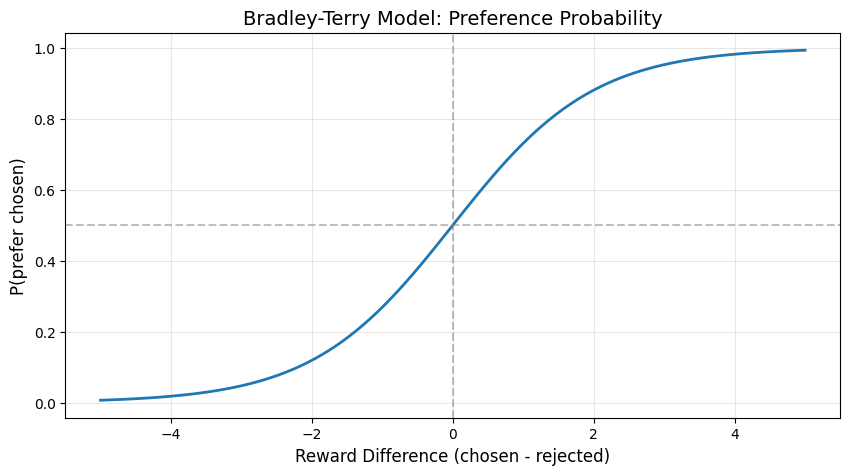

When reward_diff = 0: P(prefer chosen) = 0.5 (equal preference)
When reward_diff = 2: P(prefer chosen) = 0.88
When reward_diff = -2: P(prefer chosen) = 0.12


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Visualize the Bradley-Terry model
reward_diff = np.linspace(-5, 5, 100)
prob_prefer_chosen = 1 / (1 + np.exp(-reward_diff))  # Sigmoid

plt.figure(figsize=(10, 5))
plt.plot(reward_diff, prob_prefer_chosen, linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Reward Difference (chosen - rejected)', fontsize=12)
plt.ylabel('P(prefer chosen)', fontsize=12)
plt.title('Bradley-Terry Model: Preference Probability', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print("When reward_diff = 0: P(prefer chosen) = 0.5 (equal preference)")
print("When reward_diff = 2: P(prefer chosen) = 0.88")
print("When reward_diff = -2: P(prefer chosen) = 0.12")

## Reward Model Architecture

A reward model is typically a language model with a **value head**:

```
Input: [prompt] [response]
       ↓
┌─────────────────────────┐
│   Language Model        │  ← Pre-trained (often from SFT)
│   (frozen or trainable) │
└───────────┬─────────────┘
            │
    Hidden state of last token
            │
            ↓
┌─────────────────────────┐
│     Value Head          │  ← Trainable
│  (Linear → Scalar)      │
└───────────┬─────────────┘
            │
            ↓
       Reward Score
```

In [2]:
from transformers import AutoModel, AutoTokenizer

class RewardModel(nn.Module):
    """Reward model for predicting human preferences."""
    
    def __init__(self, base_model, hidden_size, freeze_base=False):
        super().__init__()
        self.base_model = base_model
        
        # Optionally freeze base model
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Value head: projects hidden state to scalar
        self.value_head = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        """
        Compute reward for input sequence.
        
        Returns reward at the last non-padding token.
        """
        # Get hidden states from base model
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Get last hidden state
        hidden_states = outputs.last_hidden_state  # (batch, seq, hidden)
        
        # Find position of last real token (before padding)
        # Sum attention mask to get sequence lengths
        seq_lengths = attention_mask.sum(dim=1) - 1  # -1 for 0-indexing
        
        # Extract hidden state at last position
        batch_size = hidden_states.shape[0]
        last_hidden = hidden_states[
            torch.arange(batch_size),
            seq_lengths.long()
        ]
        
        # Compute reward
        reward = self.value_head(last_hidden).squeeze(-1)
        
        return reward

# Example
model_name = "gpt2"
base_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

reward_model = RewardModel(
    base_model,
    hidden_size=base_model.config.hidden_size,
    freeze_base=False
)

print(f"Reward model created!")
print(f"Base model parameters: {sum(p.numel() for p in base_model.parameters()):,}")
print(f"Value head parameters: {sum(p.numel() for p in reward_model.value_head.parameters()):,}")

Reward model created!
Base model parameters: 124,439,808
Value head parameters: 769


## Testing the Reward Model

In [3]:
# Test forward pass
test_texts = [
    "What is 2+2? The answer is 4.",
    "What is 2+2? I don't know."
]

inputs = tokenizer(
    test_texts,
    padding=True,
    return_tensors="pt"
)

with torch.no_grad():
    rewards = reward_model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

print("Reward scores (before training):")
for text, reward in zip(test_texts, rewards):
    print(f"  '{text[:40]}...' → {reward.item():.4f}")

print("\nNote: Before training, rewards are essentially random!")

Reward scores (before training):
  'What is 2+2? The answer is 4....' → -5.9355
  'What is 2+2? I don't know....' → -7.2457

Note: Before training, rewards are essentially random!


## The Training Objective

Train the reward model to predict human preferences using the **ranking loss**:

$$\mathcal{L} = -\mathbb{E}_{(x, y_w, y_l)} \left[ \log \sigma(r_\theta(x, y_w) - r_\theta(x, y_l)) \right]$$

This loss:
- Is minimized when $r(y_w) > r(y_l)$ (correct ranking)
- Pushes chosen reward higher and rejected reward lower
- Uses log-sigmoid for numerical stability

## Next Steps

In the following notebooks, we'll cover:

1. **Preference Data** — Format, sources, and quality considerations
2. **Training** — Complete training loop implementation
3. **Evaluation** — Metrics and debugging reward hacking